In [1]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
import matplotlib.pyplot as plt
# You can also use arviz for more detailed diagnostics and visualizations
import arviz as az

# Set a random seed for reproducibility
rng_key = random.PRNGKey(0)

# Sample data (0 for NALA, 1 for EMEA)
n_samples = 1000
data = random.bernoulli(rng_key, p=0.6, shape=(n_samples,))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Text(0.5, 1.0, 'Data Distribution')

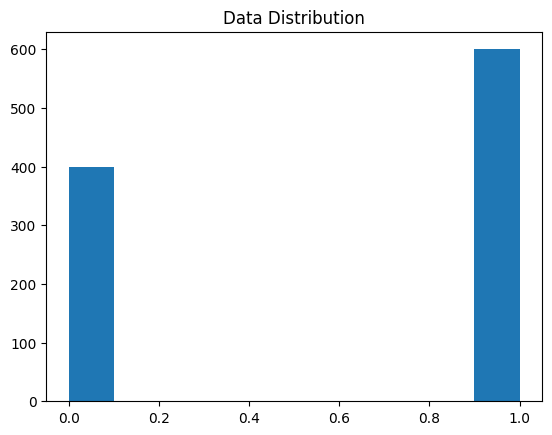

In [2]:
plt.hist(data*1);
plt.title("Data Distribution")

In [3]:
def region_model(obs=None):
    # Prior distribution for theta (probability of EMEA)
    alpha = 1
    beta = 1
    theta = numpyro.sample("theta", dist.Beta(alpha, beta))
    
    # Likelihood
    with numpyro.plate("data", len(obs) if obs is not None else 1):
        numpyro.sample("obs", dist.Bernoulli(theta), obs=obs)

# # Compile the model
# region_model = numpyro.handlers.seed(region_model, rng_key)

In [4]:
# Run MCMC
num_warmup, num_samples = 1000, 2000
mcmc = MCMC(NUTS(region_model), num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key, obs=data)

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2183.17it/s, 3 steps of size 9.46e-01. acc. prob=0.93]


In [5]:
# Get the posterior samples
samples = mcmc.get_samples()

# Print summary statistics
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.60      0.02      0.60      0.57      0.62    807.27      1.00

Number of divergences: 0


<Axes: title={'center': 'theta'}>

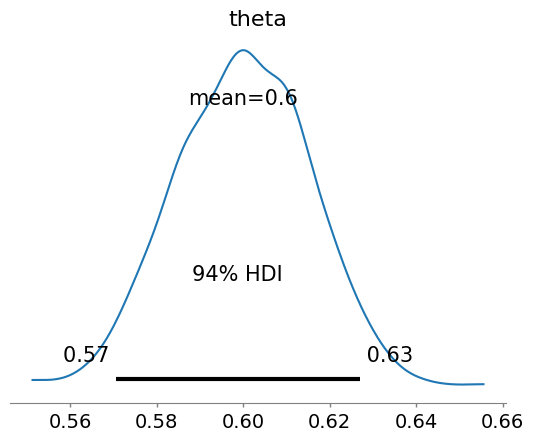

In [6]:
az.plot_posterior(mcmc, var_names=['theta'])

In [23]:
from numpyro.infer import Predictive

# After running MCMC and obtaining samples

# Create a Predictive object
predictive = Predictive(region_model, posterior_samples=samples)

# Generate predictions
predictions = predictive(rng_key, obs=None)

# Analyze the predictions
predicted_regions = predictions['obs']
prob_emea = jnp.mean(predicted_regions)
print(f"Predicted probability of EMEA: {prob_emea:.3f}")
print(f"Predicted probability of NALA: {1 - prob_emea:.3f}")

Predicted probability of EMEA: 0.603
Predicted probability of NALA: 0.397


Certainly. Modeling the product mix is an important and potentially complex part of this revenue prediction model. There are a few ways we could approach this, depending on the nature of your product mix and the level of detail you need. Let's explore some options:

1. Categorical Approach:
If you have a limited number of distinct product mix configurations, you could treat it as a categorical variable.
This approach is simple but may not capture the nuances of varying product proportions.

2. Dirichlet Distribution Approach:
If your product mix is best represented as proportions of different products, a Dirichlet distribution could be appropriate.
This allows for modeling the product mix as a vector of proportions that sum to 1.

3. Beta Distribution for Each Product:
If you want to model the proportion of each product independently:
```python
product_proportions = []
for i in range(num_products):
    prop = numpyro.sample(f"product_{i}_prop", dist.Beta(1, 1))
    product_proportions.append(prop)
product_mix = jnp.array(product_proportions)
```
This allows each product's proportion to vary independently, but doesn't ensure they sum to 1.

Dirichlet approach

[0.12148321 0.2331629  0.05335001 0.02920427 0.01971415 0.29802316
 0.00202289 0.13653031 0.07961762 0.02689151]


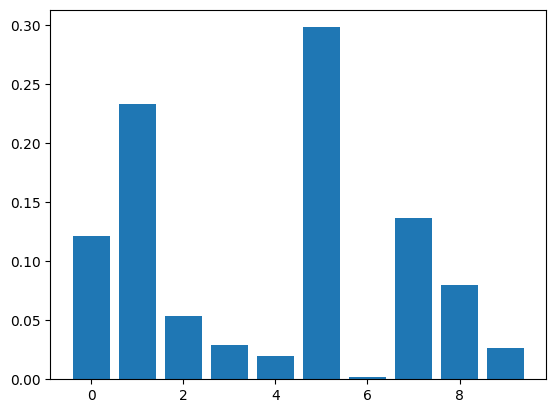

In [22]:
import numpy as np

num_products = 10
alpha = numpyro.sample("α", dist.Gamma(1, 1).expand([num_products]), rng_key=random.PRNGKey(99))
product_mix = numpyro.sample("product_mix", dist.Dirichlet(alpha), rng_key=random.PRNGKey(100))
print(product_mix)
plt.bar(np.arange(num_products), product_mix);

In [13]:
import numpy as np
from scipy.stats import dirichlet

# Prior parameters
alpha_prior = np.ones(10)  # non-informative prior

# Observed counts
observed_counts = np.array([10, 15, 5, 20, 10, 10, 10, 5, 10, 5])

# Posterior parameters
alpha_posterior = alpha_prior + observed_counts

# Sample from the posterior
posterior_samples = dirichlet.rvs(alpha_posterior, size=1000)

# Calculate expected product mix
expected_product_mix = np.mean(posterior_samples, axis=0)

print("Expected product mix:", expected_product_mix)

Expected product mix: [0.10075963 0.14698332 0.05321491 0.18958236 0.1006546  0.10085357
 0.09969531 0.05415097 0.09936273 0.0547426 ]


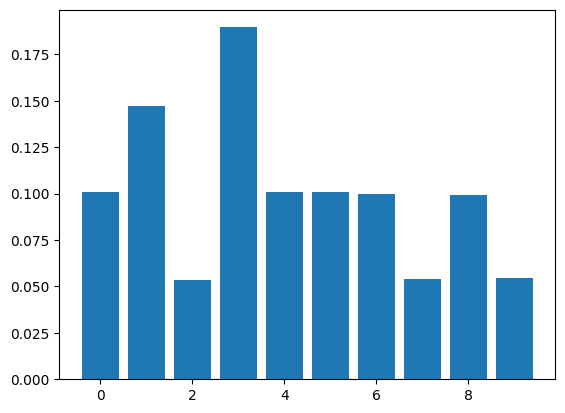

In [24]:
plt.bar(np.arange(len(expected_product_mix)), expected_product_mix);

# Gaussian Process for product mix

To model how each product's proportion changes over time using a Gaussian Process (GP), you can treat the proportion of each product as a function of time. Specifically, you can set up a separate GP for each product's proportion as a function of time. Here's a conceptual outline of the steps involved:

1. Data Structure
    * You have a time series of obs, where at each time point $t$, you observe the proportions of each product. Let $P_i(t)$ denote the proportion of product $i$ at time $t$
2. GP Model for Each Product
For each product $i$, model its proportion $P_i(t)$ over time using a Gaussian Process. This means $P_i(t)$ is assumed to be a draw from a GP with some mean function μi(t)$mu\_i(t)μi​(t)$ and covariance function $k_i(t, t')$.
3. Choose appropriate mean and covariance functions for the GP

Next: 

1. Define a GP model for each product's proportion over time
2. Perform a MCMC inference to sample from posterior distributions of GP hyperparameters for each product
3. Posterior predicitons - use posterior samples to make preds about future product proportions



In [25]:
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.handlers import trace, seed


2. Generate synthetic data

In [26]:
def generate_data(num_products=10, num_time_points=50):
    time_points = np.linspace(0, 10, num_time_points)
    proportions = np.array([np.sin(time_points + np.random.randn()) for _ in range(num_products)])
    proportions = proportions / proportions.sum(axis=0)  # Normalize to get proportions
    return time_points, proportions

time_points, proportions = generate_data()


3. Define the kernel

In [27]:
def rbf_kernel(x, y, length_scale, variance):
    sqdist = jnp.sum(x**2, 1).reshape(-1, 1) + jnp.sum(y**2, 1) - 2 * jnp.dot(x, y.T)
    return variance * jnp.exp(-0.5 / length_scale**2 * sqdist)


4. GP model for one product:

In [32]:
def gp_model(time_points, proportions=None):
    length_scale = numpyro.sample("length_scale", dist.LogNormal(0.0, 1.0))
    variance = numpyro.sample("variance", dist.LogNormal(0.0, 1.0))
    noise = numpyro.sample("noise", dist.LogNormal(0.0, 1.0))
    
    K = rbf_kernel(time_points[:, None], time_points[:, None], length_scale, variance) + noise * jnp.eye(len(time_points))
    
    numpyro.sample("proportions", dist.MultivariateNormal(loc=jnp.zeros(len(time_points)), covariance_matrix=K), obs=proportions)


5. Run MCMC inference for each product

In [33]:
rng_key = random.PRNGKey(0)
num_products = proportions.shape[0]

mcmc_results = []
for i in range(num_products):
    nuts_kernel = NUTS(gp_model)
    mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
    mcmc.run(rng_key, time_points, proportions[i])
    mcmc_results.append(mcmc.get_samples())


sample: 100%|██████████| 1500/1500 [00:04<00:00, 369.60it/s, 1 steps of size 7.42e-01. acc. prob=0.82]


6. Posterior Predictions:

In [34]:
def predict(time_new, time_points, samples, Y):
    predictions = []
    for i in range(len(samples['length_scale'])):
        length_scale = samples['length_scale'][i]
        variance = samples['variance'][i]
        noise = samples['noise'][i]

        K = rbf_kernel(time_points[:, None], time_points[:, None], length_scale, variance) + noise * jnp.eye(len(time_points))
        K_s = rbf_kernel(time_points[:, None], time_new[:, None], length_scale, variance)
        K_ss = rbf_kernel(time_new[:, None], time_new[:, None], length_scale, variance) + 1e-8 * jnp.eye(len(time_new))

        K_inv = jnp.linalg.inv(K)
        mu_s = jnp.dot(K_s.T, jnp.dot(K_inv, Y))
        predictions.append(mu_s)
    
    return jnp.mean(jnp.array(predictions), axis=0)

time_new = np.linspace(0, 10, 100)
posterior_predictions = []

for i in range(num_products):
    Y_pred = predict(time_new, time_points, mcmc_results[i], proportions[i])
    posterior_predictions.append(Y_pred)

posterior_predictions = np.array(posterior_predictions)


7. Plot the results

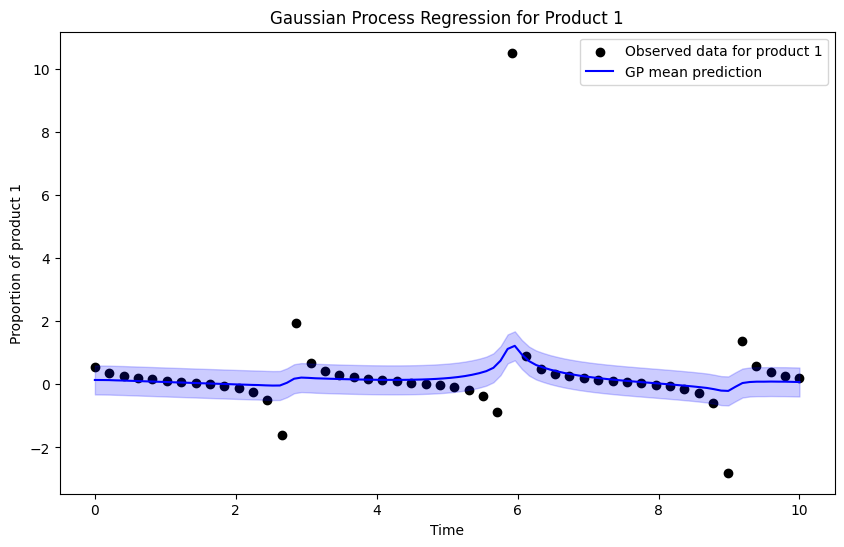

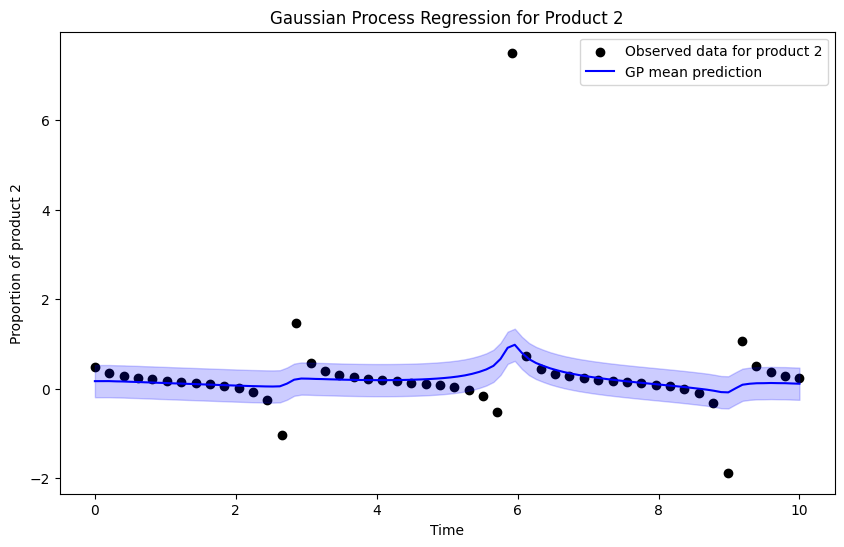

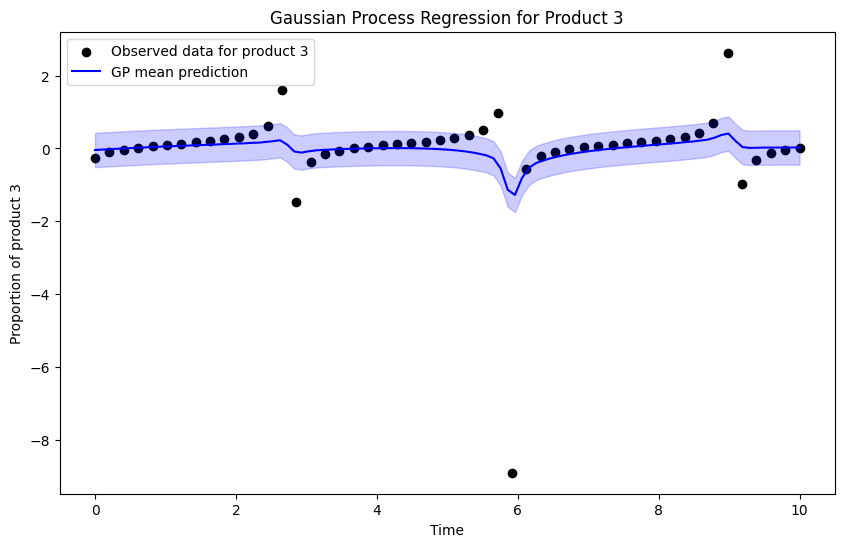

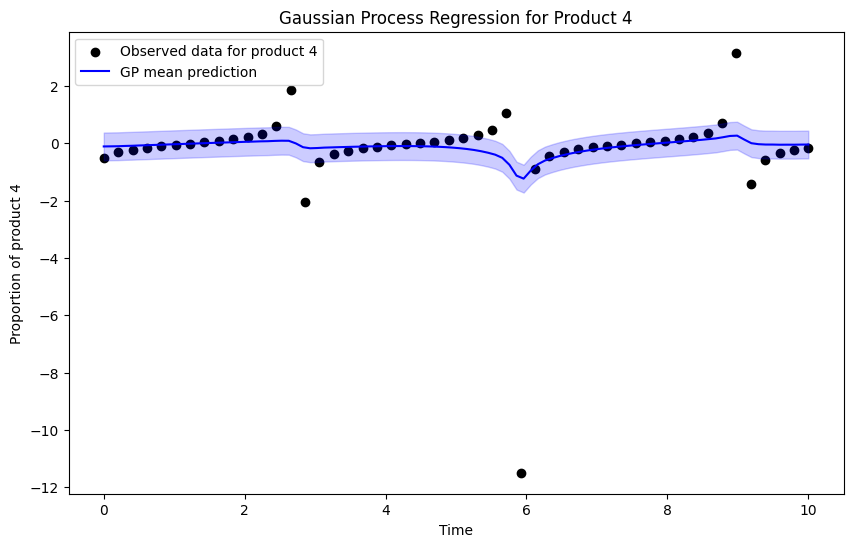

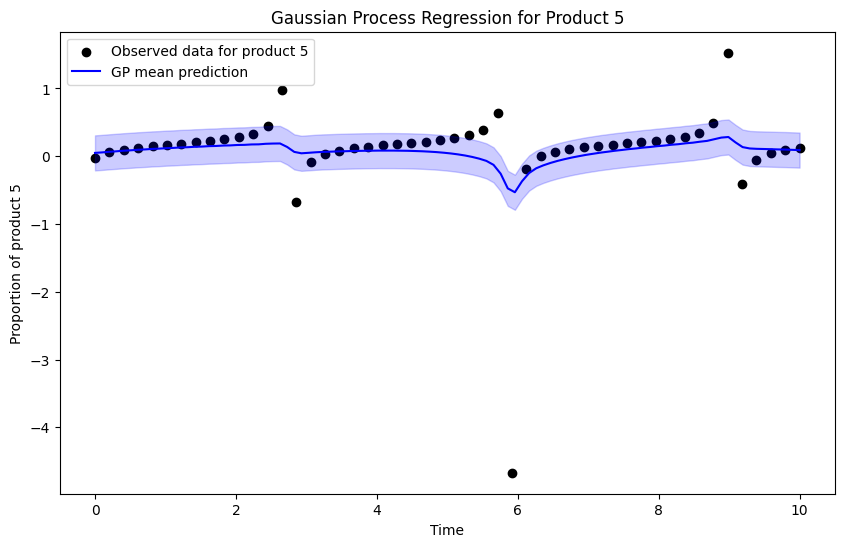

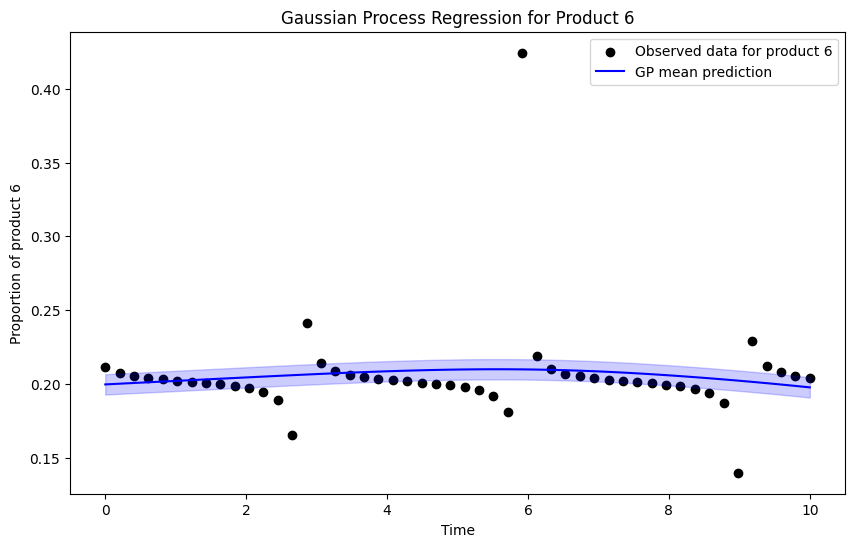

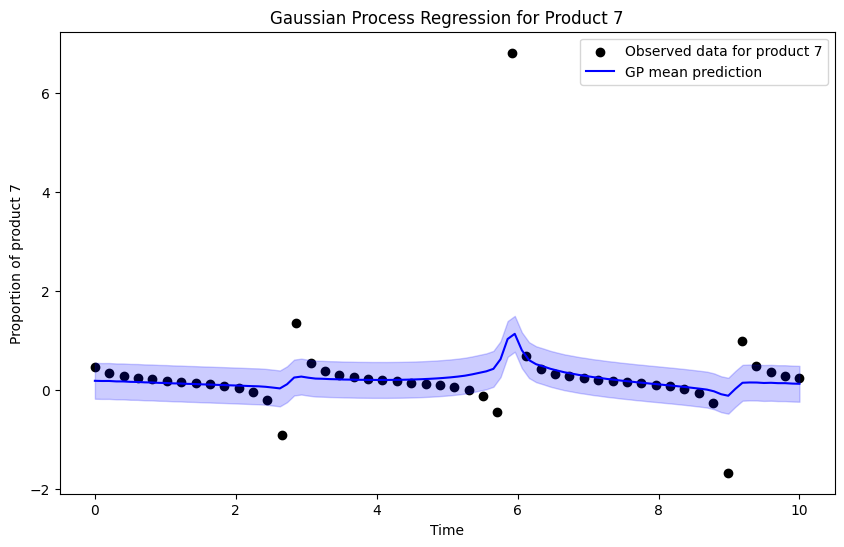

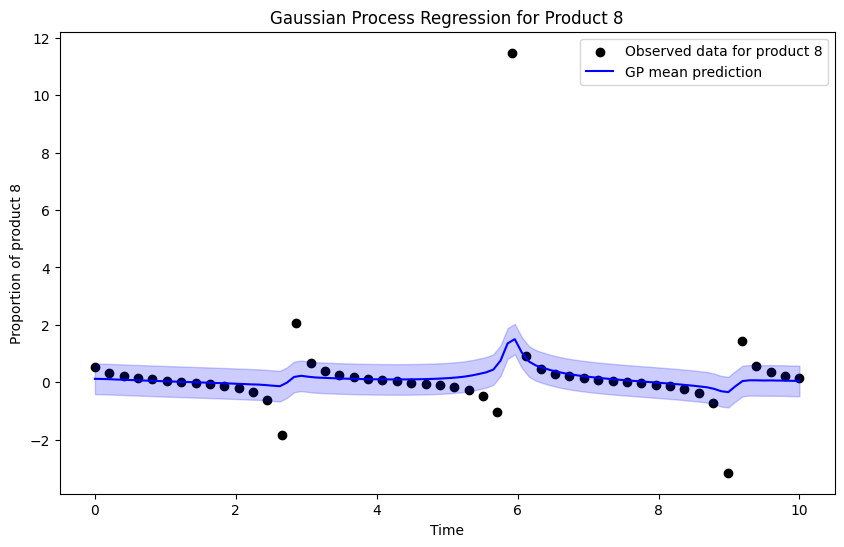

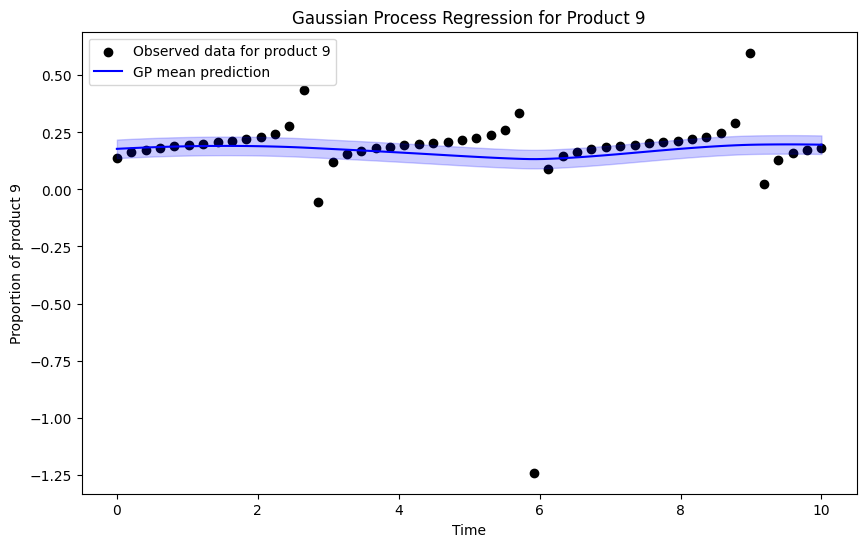

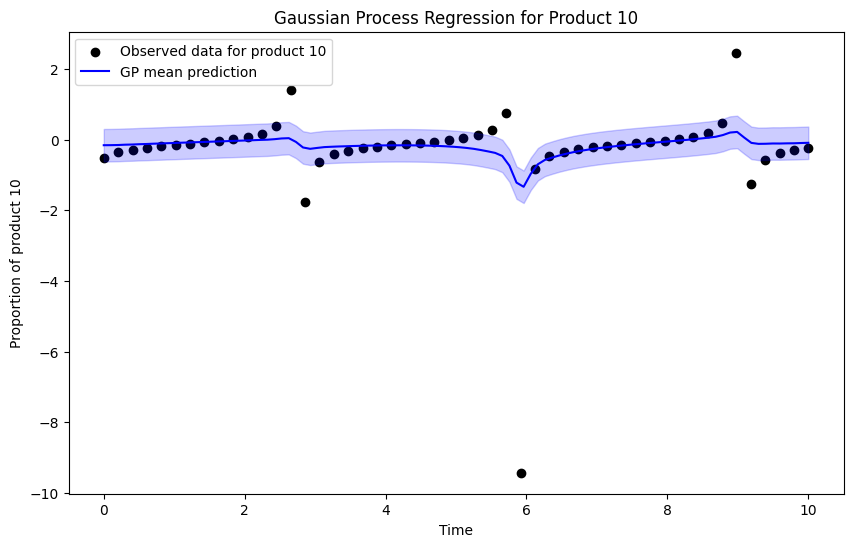

In [35]:
import matplotlib.pyplot as plt

for i in range(num_products):
    plt.figure(figsize=(10, 6))
    plt.scatter(time_points, proportions[i], color='black', label=f'Observed data for product {i+1}')
    plt.plot(time_new, posterior_predictions[i], color='blue', label='GP mean prediction')
    plt.fill_between(time_new, posterior_predictions[i] - 1.96 * np.std(posterior_predictions[i]), posterior_predictions[i] + 1.96 * np.std(posterior_predictions[i]), alpha=0.2, color='blue')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(f'Proportion of product {i+1}')
    plt.title(f'Gaussian Process Regression for Product {i+1}')
    plt.show()
